# Stroke prediction


#### Data source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### Importing libraries

In [1]:
# inline plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


### Importing dataset

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')
print("Dataset info:")
print( "Data shape: ", df.shape)
print(df.head())
print("="*80)
print(df.isnull().sum())

Dataset info:
Data shape:  (5110, 12)
      id  gender   age  hypertension  heart_disease ever_married   
0   9046    Male  67.0             0              1          Yes  \
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status   
0        Private          Urban             228.69  36.6  formerly smoked  \
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
id                

In [3]:
# Fill missing values with mean column values in the dataframe
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
# drop id column
df.drop('id', axis=1, inplace=True)
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [4]:
# apply one hot encoding to categorical features and replace them with the new columns
cathegorial_fetures = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=cathegorial_fetures, dtype=int)
# Move stroke as the last column
stroke = df.pop('stroke')
df['stroke'] = stroke
print(df.head())

    age  hypertension  heart_disease  avg_glucose_level        bmi   
0  67.0             0              1             228.69  36.600000  \
1  61.0             0              0             202.21  28.893237   
2  80.0             0              1             105.92  32.500000   
3  49.0             0              0             171.23  34.400000   
4  79.0             1              0             174.12  24.000000   

   gender_Female  gender_Male  gender_Other  ever_married_No   
0              0            1             0                0  \
1              1            0             0                0   
2              0            1             0                0   
3              1            0             0                0   
4              1            0             0                0   

   ever_married_Yes  ...  work_type_Private  work_type_Self-employed   
0                 1  ...                  1                        0  \
1                 1  ...                  0       

### Data analysis

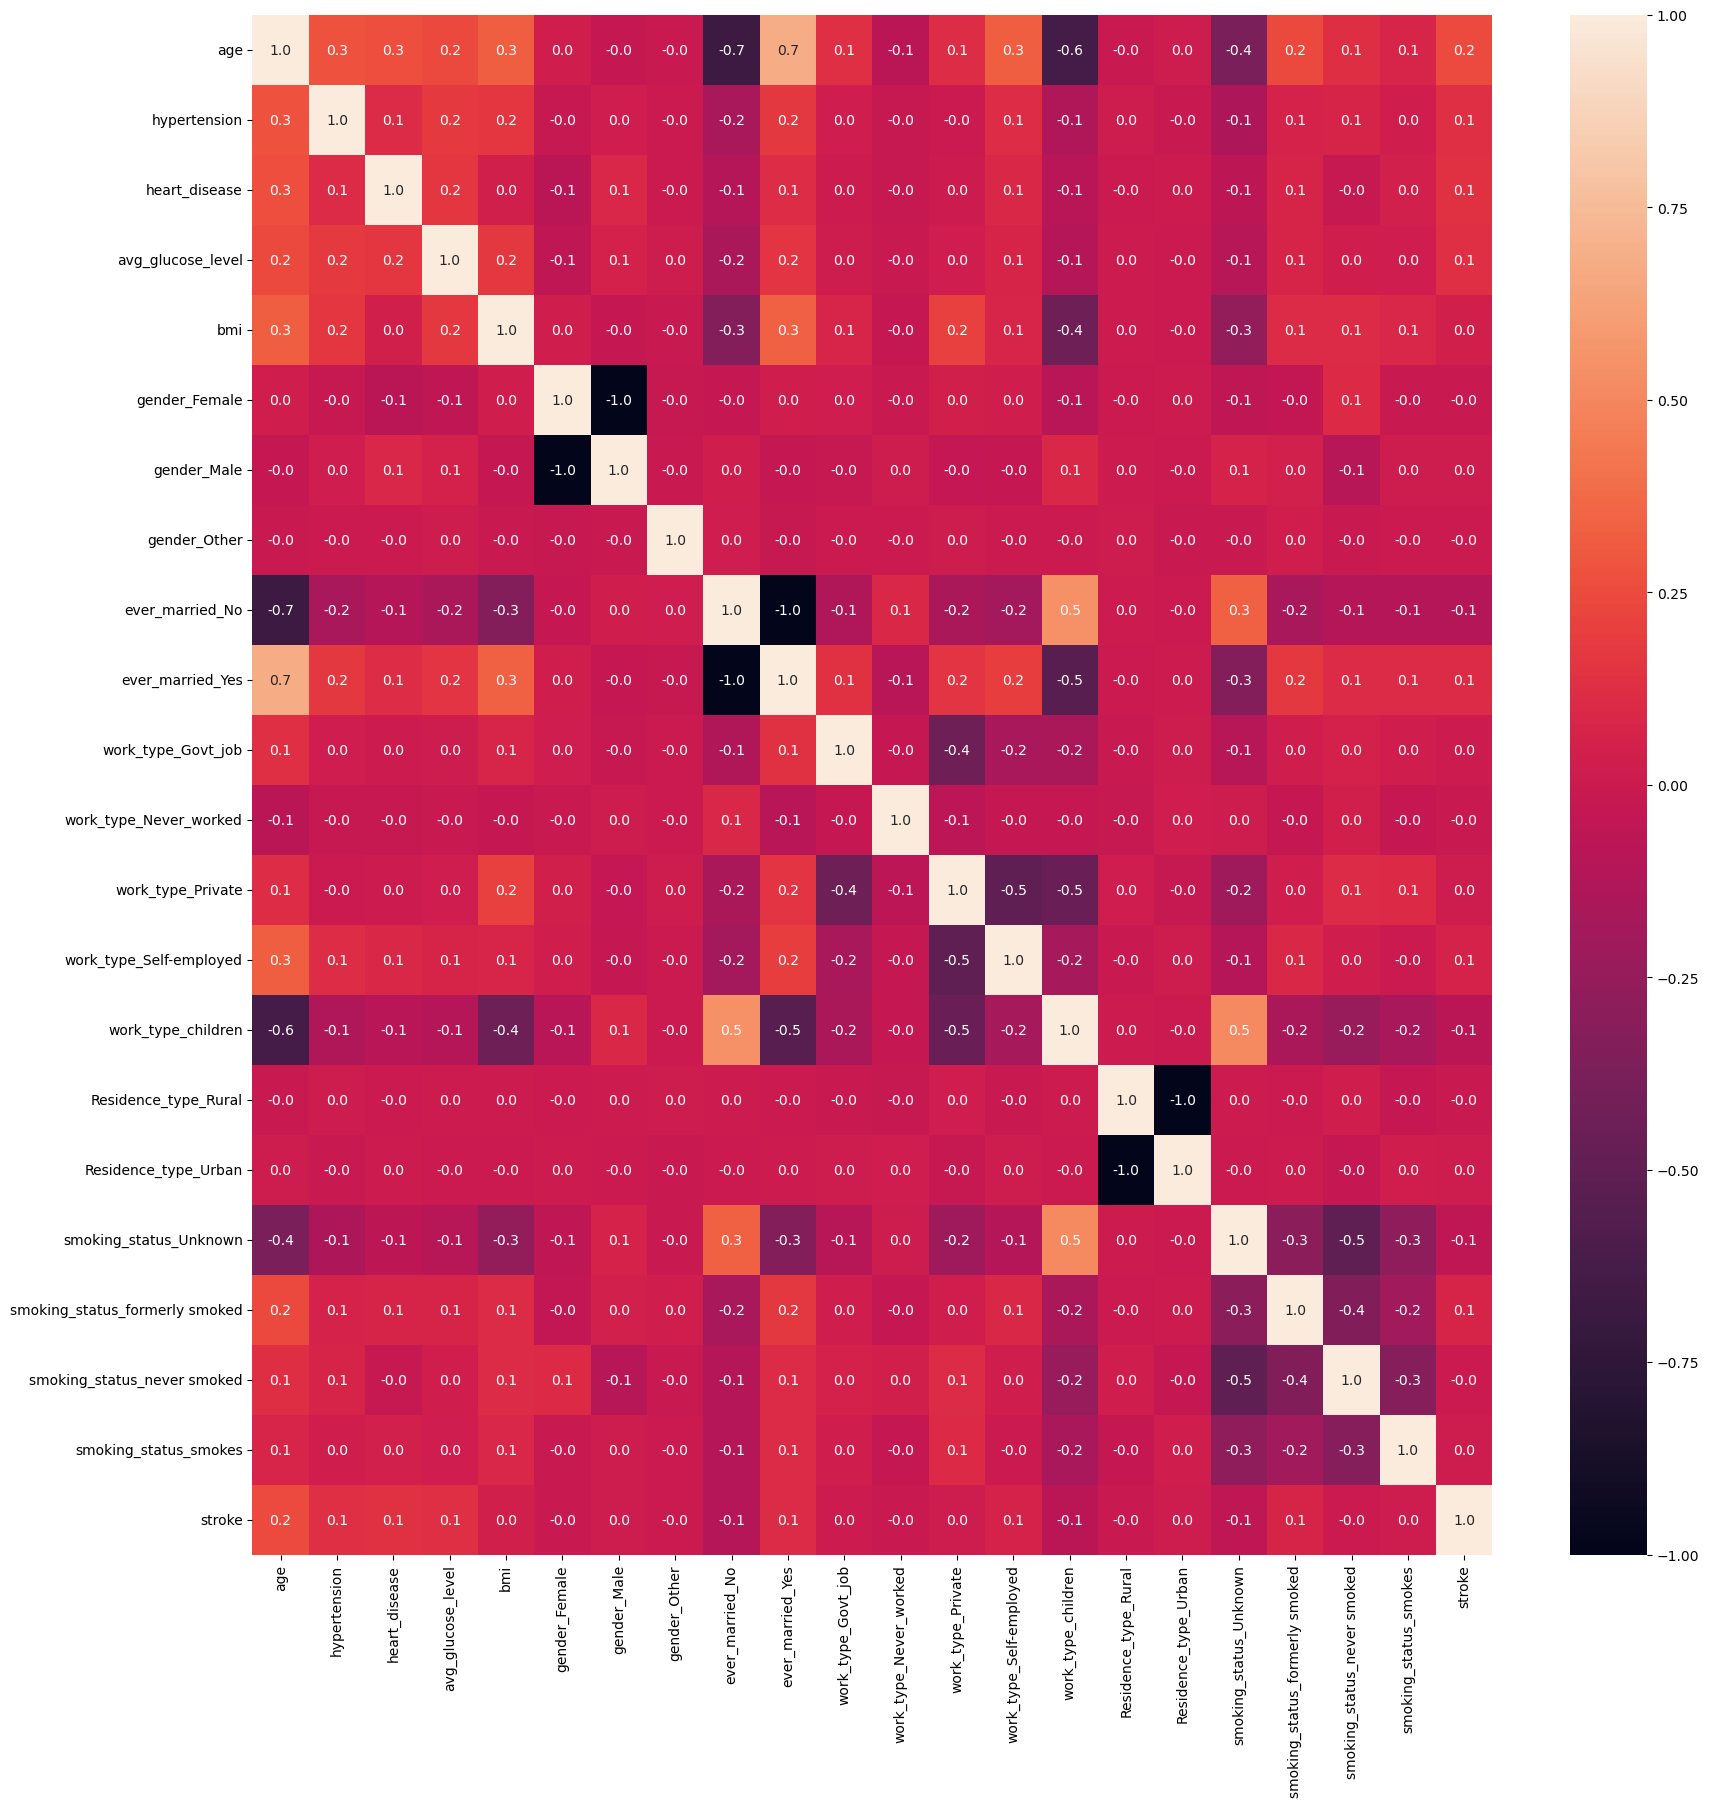

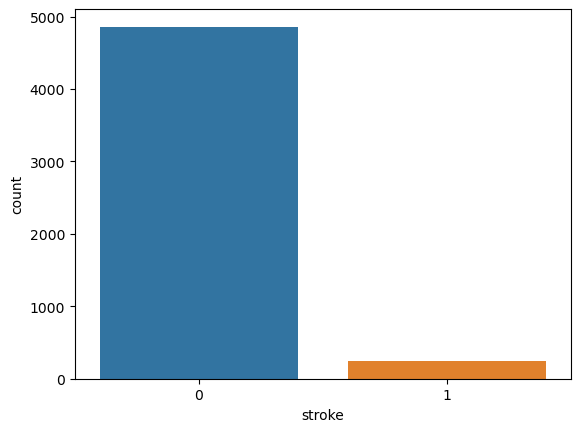

In [5]:
# Check the correlation between features
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.1f')
plt.show()

# more analysis
sns.countplot(x='stroke', data=df)
plt.show()


#### Observations
The stroke appears to have correlation between the following variables:
* Age
* hypertension
* heart_disease
* glucose_level

In [6]:
# Split the data into train and test maintaining the same distribution of the target variable
from sklearn.model_selection import train_test_split
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1313, stratify=y)


In [7]:
# Oversampling the minority class
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())


## Model evaluation

In [8]:
# generate multiple models and compare them
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

# Tensorflow for deep learning models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



In [9]:
# create NN model for deep learning approach
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_resh.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:

# evaluate each model in turn
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=1313))])
dtc_pipeline = Pipeline(steps = [('scale',StandardScaler()),('DTC',DecisionTreeClassifier(random_state=1313))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=1313))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=1313))])
knn_pipeline = Pipeline(steps = [('scale',StandardScaler()),('KNN',KNeighborsClassifier())])
xgb_pipeline = Pipeline(steps = [('scale',StandardScaler()),('XGB',XGBClassifier(random_state=1313))])
nn_pipeline = Pipeline(steps = [('scale',StandardScaler()),('NN',KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=0))])

C:\Users\cesar\AppData\Local\Temp\ipykernel_42756\1346953883.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_pipeline = Pipeline(steps = [('scale',StandardScaler()),('NN',KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=0))])


In [11]:
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
dtc_cv = cross_val_score(dtc_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
knn_cv = cross_val_score(knn_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
xgb_cv = cross_val_score(xgb_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
nn_cv = cross_val_score(nn_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

22/22 [==============================] - 0s 810us/step


In [12]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('DRC mean :',cross_val_score(dtc_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('KNN mean :',cross_val_score(knn_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('XGB mean :',cross_val_score(xgb_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('NN mean :',cross_val_score(nn_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9650126704713843
SVM mean : 0.9562260001894787
Logistic Regression mean : 0.9556602320840847
DRC mean : 0.940693528039106
KNN mean : 0.9624757821556245
XGB mean : 0.9565286095315455
22/22 [==============================] - 0s 2ms/step
NN mean : 0.5837128890415538
